# Turing Machine and Deep Learning

## Assignment 2: Supervised Classification Problems

This notebook is meant for you to review and reflect on the content of Lecture 2, which was mainly about supervised learning problems in the general context of classification. We will reflect mainly on model and hyperparameter selection over the models we have discussed during the lecture: logistic regression, decision trees, random forests and support vector machines. This notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


# Question 1 -- Classification Metrics

To contextualise, we learnt of 4 metrics in class: accuracy, precision, recall and F1 score. Answer the following text questions in the following markdown cell.
1. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would be preferable.
2. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would fail.
3. In which situations would the F1 score be helpful? Give one concrete example.

Preferable example

*   Accuracy- Image classification in autonomous vehicles, high accuracy will minimize the risk of getting into accidents.

*   Precision- Diagnonsis of cancer, a model with high precision can correctly predict is someone has cancer or not which minimizing unnecessary surgeries or treatments.

*   Recall- Fraud detection in bank, high recall will capture all the fradulent activites which minimizes the financial losses.

Fail example

*   Accuracy- Classifying an imbalanced dataset, if one scenarios overweights the other scenario then their can be high accuracy when prediciting but the actual prediction might not be correct.

*   Precision- testing for rare diseases,scenarios where the positive class (e.g., individuals with a rare disease) is highly outnumbered by the negative class (e.g., individuals without the disease), false postivites will be more than true positives.

*   Recall- email spam filter can fail to detect the spam as their are many email coming in which may not be spam hence the model can missclassify them.

When F1 score would be helpful when there is an imbalance between precision and recall. One example is information retrieval system.
*   Precision: Measures with the documents being retrieved how many are relevant. High precision means that the search engine returns very few irrelevant results.
*   Recall: Measures the proportion of relevant documents that are successfully retrieved by the search engine. High recall indicates that the search engine retrieves most of the relevant documents available.

In information retrieval, we want both score to be high which many not be possible as there can be a trade-off hence, having F1 score provides with one single metric to balance both the score and ensure information retrieval system is working.

## Question 2 -- CIFAR 10

As we've discussed last week, one of the prime issues with ML is figuring out what model you are going to use and when. In this case, we're going to use the [CIFAR-10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) dataset from TensorFlow, another benchmarking dataset. This is a considerably larger dataset, and contains coloured images. For the sake of computation time, we are just going to use the first 1000 training images but the full test set (though in a proper ML setting we would prefer to use all training data). The images are 32x32 coloured pixes. There are 10 labels which are integers by default. The dictionary `class_labels` translate them to their text label equivalents (referenced from [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)).

170498071/170498071 [==============================] - 6s 0us/step


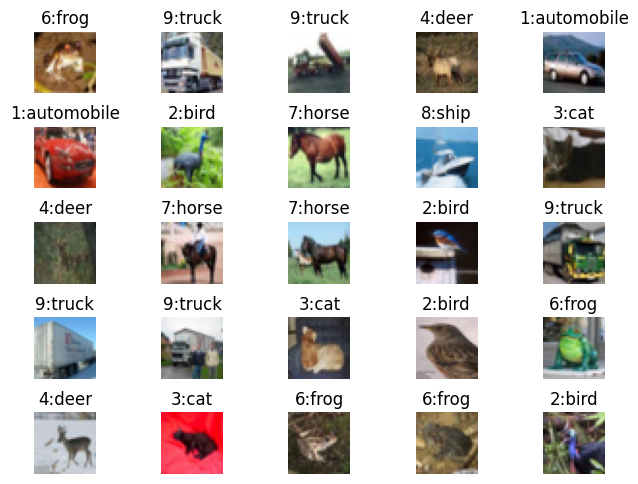

In [1]:
# don't need to edit anything here,
# just run this cell

# get dataset
from tensorflow.keras.datasets import cifar10
# get common libraries
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # this is a new one: makes loading bars

def get_data_subset(n_train, n_test):
    (train_X, train_y), (test_X, test_y) = cifar10.load_data()
    train_X, train_y, test_X, test_y = train_X[:n_train], train_y[:n_train], test_X[:n_test], test_y[:n_test]
    train_y, test_y = train_y.squeeze(), test_y.squeeze()
    return train_X, train_y, test_X, test_y

n_train, n_test = 1000, 1000

train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)

fig, axs = plt.subplots(5,5)
axs = axs.flatten()
fig.tight_layout(pad=0.3)

class_labels = {0:"airplane",
                1:"automobile",
                2:"bird",
                3:"cat",
                4:"deer",
                5:"dog",
                6:"frog",
                7:"horse",
                8:"ship",
                9:"truck"}

for i, ax in enumerate(axs):
    ax.imshow(train_X[i])
    ax.set_title(f"{train_y[i]}:{class_labels[train_y[i]]}")
    ax.axis("off")

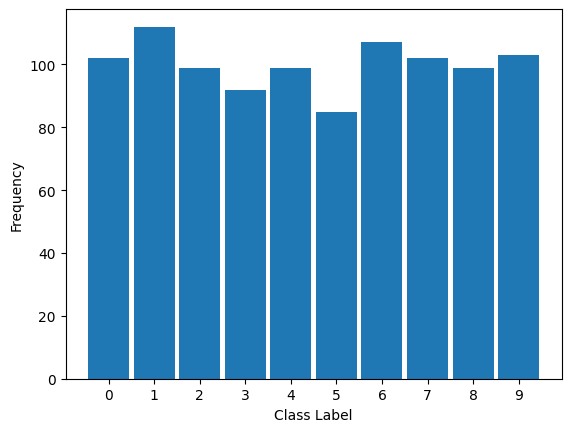

In [2]:
# making sure the quantity of examples for each label are about the same
plt.hist(train_y, bins=10, rwidth=0.9)
plt.xticks(0.9*np.arange(10)+0.45, range(10))
plt.ylabel("Frequency")
plt.xlabel("Class Label")
plt.show()

## Question 2.1 -- Preprocessing

The first thing we should do is preprocess the images so that they are ready to be input into our models. First, print out the shape of the dataset's inputs (`train_X`).

In [3]:
print(train_X.shape)

(1000, 32, 32, 3)


**Q 2.1.1** What does each value in the tuple that was printed out mean?

1000 is the number of samples,

32 is the pixel for both sides, height and width,

3 is the number of channel (RGB)

**Q 2.1.2** Next, flatten the pixel values to a single vector. What is the length of this vector? Print out the shape of the flattened dataset's inputs once more.

In [4]:
def flatten_cifar10(samples):
    return samples.reshape((len(samples), 32*32*3))


train_X, test_X = flatten_cifar10(train_X), flatten_cifar10(test_X)

# Print the length of the flattened vector
print("Length of flattened vector:", train_X.shape[1])

# Print out the shape of the flattened dataset's inputs
print("Shape of flattened train_X:", train_X.shape)



Length of flattened vector: 3072
Shape of flattened train_X: (1000, 3072)


## Question 3 -- Model Selection using Grid Search

In the lecture, we have seen four different ML classification algorithms: logistic regression, decision trees, random forests and support vector machines. In this assignment, we will figure out which is best, and a basic method to figure out the best way to tune the parameters of each one. Remember, a hyperparameter is something that you choose by hand about the model or the way it trains.

### Question 3.1 -- Logistic regression

Use `sklearn` (as in the lecture notebook) to classify the CIFAR10 sub-dataset. There are not a lot of major hyperparameters to tune here, so this exercise should be straightforward. Create a LogisticRegression object, fit it on the training data, and compute the train and test accuracies.

*Expected runtime: ~1min*

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

modelLR = LogisticRegression(max_iter=1000)

modelLR.fit(train_X, train_y)

# Print training and testing scores
print("Training score:", modelLR.intercept_)
print("Testing score: ", modelLR.coef_)

test_predictions = modelLR.predict(test_X)

accuracy = accuracy_score(test_y, test_predictions)
print("Testing accuracy:", accuracy)

from sklearn.metrics import classification_report

print("Logistic Regression")
print(classification_report(test_y, test_predictions, digits=4))


Training score: [-3.07365631e-04  4.30570280e-05 -7.23007833e-05  9.22848647e-05
  1.12375944e-04  8.09043182e-05  2.43600639e-04 -3.09515200e-06
 -1.98728873e-04  9.26764519e-06]
Testing score:  [[ 4.11992316e-04  8.53061201e-04  2.30233462e-04 ... -3.68123704e-03
  -2.00786472e-03 -7.89765763e-04]
 [ 2.45333964e-03  5.53104687e-04 -2.71666012e-05 ... -6.87865075e-04
  -6.36798208e-04 -2.17564062e-03]
 [-2.44598215e-03 -1.83713535e-03 -4.98755539e-03 ... -8.72489136e-04
  -9.40892902e-04 -2.11409904e-03]
 ...
 [-1.66953644e-03 -2.52601527e-04 -1.90908712e-03 ...  2.47502146e-03
   2.92523466e-03  1.43084902e-03]
 [-2.27009210e-03 -2.11746293e-03  1.62525060e-04 ... -3.29514499e-03
  -1.66347317e-03  3.41864758e-04]
 [ 5.11262563e-04  1.84405966e-03  4.64868376e-03 ...  2.67892597e-03
   3.24971467e-03  3.32451079e-03]]
Testing accuracy: 0.267
Logistic Regression
              precision    recall  f1-score   support

           0     0.2925    0.3010    0.2967       103
           1   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Q 3.1.2** Does the model work well in your opinion? What about whether it is over/underfitting?

In [6]:
def get_accuracies(model, train_X, train_y, test_X, test_y):
    print("Training score:", model.score(train_X, train_y))
    print("Testing score: ", model.score(test_X, test_y))

get_accuracies(modelLR, train_X, train_y, test_X, test_y)

Training score: 1.0
Testing score:  0.267


The accuracy of the model is only 0.265 which is not very high hence, the model is not working well. I think this is overfitting the data as the model is capturing noise and random fluctuations in the training data, rather than the underlying patterns.

### Question 3.2 -- Decision Trees

Decision trees have one main hyperparameter that you can tune -- this is the maximum depth of the tree being trained. Thus, we'll try and figure out what depth is the optimal for our purposes.

An important thing to note is that decision trees are randomized initially -- this means that two trees of the same depth may have wildly different performances, depending on how they were initialized.

**Q 3.2.1** Loop over max tree depths from $d=1$ to $d=15$ and store the mean and standard deviation of train and test scores for 10 randomly initialised trees.

*Expected runtime: <5 mins*

In [7]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

train_acc_mean, train_acc_std = [], [] # to store the training accuracies
test_acc_mean, test_acc_std = [], []   # to store the testing accuracies
depth_range = range(1,16)
for d in tqdm(depth_range): # loop over tree depths
    train_perfs = [] # store interem train scores
    test_perfs = []  # store interem test scores
    for n in range(10):   # loop over random initializations
        modelDT = tree.DecisionTreeClassifier(max_depth=d)
        modelDT.fit(train_X, train_y)
        train_pred = modelDT.predict(train_X)
        test_pred = modelDT.predict(test_X)
        train_accuracy = accuracy_score(train_y, train_pred)
        test_accuracy = accuracy_score(test_y, test_pred)
        train_perfs.append(train_accuracy)
        test_perfs.append(test_accuracy)

    # append mean and std scores to appropriate lists
    train_acc_mean.append(np.mean(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.mean(test_perfs))
    test_acc_std.append(np.std(test_perfs))


100%|██████████| 15/15 [04:25<00:00, 17.73s/it]


**Q 3.2.2** Plot the test and train means with errorbars equal to one standard deviation (look at [plt.errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) for reference). Don't forget to add labels.

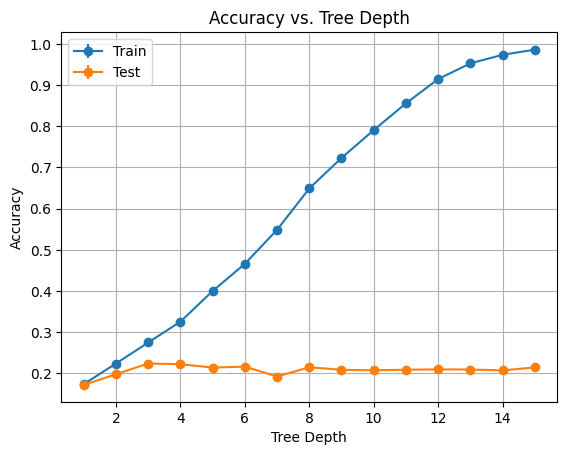

Decision Tree
Training score: 0.984
Testing score:  0.21


In [8]:
import matplotlib.pyplot as plt

plt.errorbar(depth_range, train_acc_mean, yerr=train_acc_std, label='Train', fmt='-o')

plt.errorbar(depth_range, test_acc_mean, yerr=test_acc_std, label='Test', fmt='-o')

plt.title('Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid()

plt.legend()

plt.show()

print("Decision Tree")
get_accuracies(modelDT, train_X, train_y, test_X, test_y)


**Q 3.2.3**

1. Is there a lot of variation of the performance of the trees (enough to question statistical significance)?
2. Which model (of the ones you tested) performed best on the training set? Which performed best on the test set?
3. At what depth do models start to overfit the training data?

Yes, there is alot of variation because training accuracy increase with the depth but testing is quite similar even with increased depth. Logistic Regression is a better model as the testing score is 0.265 which is higher than 0.222. Training score of logistic is better than decision tree. It is hard to say but around 6.

## Question 3.3 -- Random Forests
Just like in the decision trees, one hyperparameter you can choose is the depth of the tree. However, another important one is the number of decision trees. In this case, the performance is affected by the combination of these hyperparameters, and so we need to train and evaluate them at each combination.

**Q 3.3.1** Loop over $n_{trees}=10$ to $n_{trees}=100$ in increments of 10, and max tree depths from $d\in[1,3,5,7,9,11,13,15]$ and store the mean and standard deviation of train and test scores for 5 randomly initialised trees.

*Expected runtime: ~9 minutes*

In [9]:
from sklearn.ensemble import RandomForestClassifier as RFC
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

train_acc_mean, train_acc_std = np.zeros((10, 8)), np.zeros((10, 8)) # storing it in an np array instead of a list makes it easier
test_acc_mean, test_acc_std = np.zeros((10, 8)), np.zeros((10, 8))

n_trees = range(10, 101, 10)
depths = [1, 3, 5, 7, 9, 11, 13, 15]

for tree_idx, n_tree in tqdm(enumerate(n_trees), total=len(n_trees)):
    for d_idx, depth in enumerate(depths):
        train_perfs = []
        test_perfs = []
        for _ in range(5):
            modelRFC = RFC(n_tree, max_depth=depth)
            modelRFC.fit(train_X, train_y)
            train_pred = modelRFC.predict(train_X)
            test_pred = modelRFC.predict(test_X)
            train_perfs.append(accuracy_score(train_y, train_pred))
            test_perfs.append(accuracy_score(test_y, test_pred))
        train_acc_mean[tree_idx][d_idx] = np.mean(train_perfs)
        train_acc_std[tree_idx][d_idx] = np.std(train_perfs)
        test_acc_mean[tree_idx][d_idx] = np.mean(test_perfs)
        test_acc_std[tree_idx][d_idx] = np.std(test_perfs)

100%|██████████| 10/10 [09:00<00:00, 54.09s/it]


Looping over several variables and testing each combination is called a **grid search**. Since we have two hyperparameters, we cannot plot a 1D line to see which is best, as we did for normal DTs. One way to visualize this instead is a heatmap. For this, we can `seaborn`'s [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function.  

**Q 3.3.2** Plot two heatmaps: one for the train accuracies and one for the test ones.

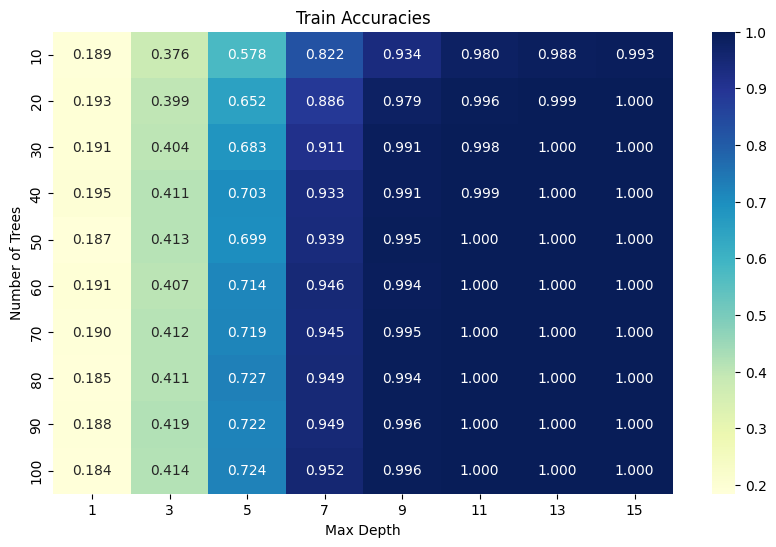

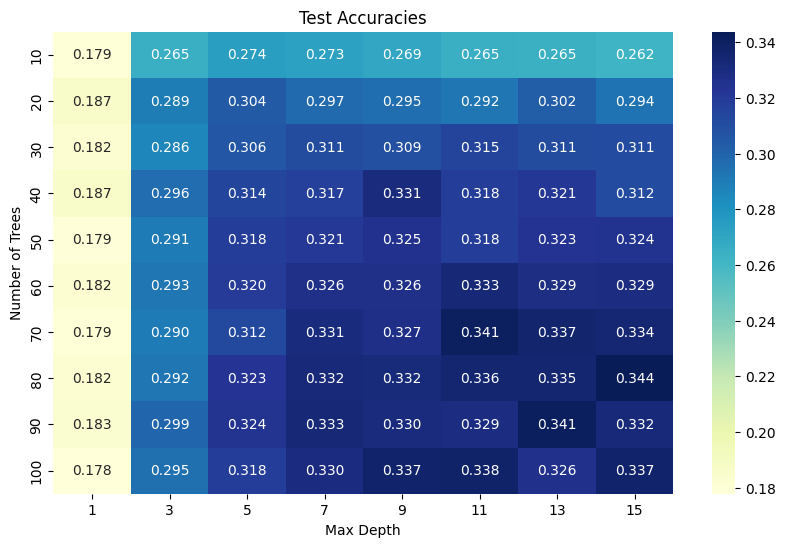

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Figure 1
plt.figure(figsize=(10, 6))  # adjust figure size as needed
sns.heatmap(train_acc_mean, annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=depths, yticklabels=n_trees)
plt.title("Train Accuracies")
plt.xlabel("Max Depth")
plt.ylabel("Number of Trees")
plt.show()

# Figure 2
plt.figure(figsize=(10, 6))  # adjust figure size as needed
sns.heatmap(test_acc_mean, annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=depths, yticklabels=n_trees)
plt.title("Test Accuracies")
plt.xlabel("Max Depth")
plt.ylabel("Number of Trees")
plt.show()


**Q 3.3.2**
1. What trends with respect to each hyperparameter do the heatmaps show you?
2. What model performs best on the train set? What model performs best on the test set?
3. What model would you choose to deploy and why?

For training dataset, it can be seen that depth 9 to 15 gives the highest accuracy regardless of the number of trees. For testing dataset, it can inferred that 100 trees with 11 depth gives the best result which is 0.347. But generally depth from 9 to 15 and number of trees from 70 to 100 gives the highest accuracy.
Both logistic and random forest have an accuracy of one but logisitc is faster in terms of computational time for training dataset. Regarding testing data set, random forest is better as it has an accuracy of 0.347. I would choose to deploy random forest we have time and resources to run the model else logisitc regression will be fine as well as an alternative.

## Question 3.4 -- Support Vector Machines

`sklearn`'s SVM classifier implementation (called "SVC", we already met them in the lecture) contains quite a number of hyperparameters you can tune. The ones we are looking at today are the kernel, the parameter `C` (which is some penalty term for incorrectly classifying a data point, applicable to the RBF kernel), `gamma`, which is a measure of how important closer points to the decision boundary are with respect to the decision boundary (applicable to the RBF kernel), and `degree`, which is the degree of the polynomial function (applicable to the poly kernel). Let $C\in\{0.1, 1, 10, 100\}$ and $gamma\in\{10^x|-2\leq x\leq 2, x\in\mathbb{Z}\}$. Let us use $degree\in\{2,3,4\}$.

A note about the kernel: In short, this is a function that determines what the shape of the decision boundary are. The choices that we can check out here (there are more) are `linear` (linear decision boundary), `poly` (polynomial) and `rbf` (radial basis function) in order of flexibility.

Since we are trying to optimize for a number of different parameters, writing out all the code ourselves gets a bit messy. Instead, we use `sklearn` again! The class in question is called `GridSearchCV`, which performs a grid search over parameters with specified values.

The 'CV' part of the name refers to the fact that we are performing *cross-validation*, which is related to the concept of validation sets that we encountered last week. We will cover it in a future lecture, but for now, the way it works is that it splits the training set into $k$ sets (called 'folds') and iteratively trains on $k-1$ folds and validates on the remaining one. The result is the mean over $k$ iterations. CV is considered the 'gold standard' with respect to analysing model robustness. We will use $k=5$ (appropriately called *5-fold cross-validation*), which is standard for a first analysis.

**Q 3.4.1** Run a gridsearch with 5-fold cross-validation over the hyperparameters discussed above to find an optimal SVC model. Please look at GridSearchCV's documentation for more information.

*Expected runtime: Around 15 minutes if you're lucky.*

**Q 3.4.2**
1. How many combinations of parameters are there? Why?
2. Using 5-fold validation, how many models do you train in total?

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_svm = [
    {'kernel': ['linear', 'poly', 'rbf'],
     'C': [0.1, 1, 10, 100],
     'degree': [2, 3, 4],
     'gamma': [10**x for x in range(-2, 3)]}
]

print("Parameter grid for SVM:")
print(param_grid_svm)

# create the cross-validation object
optimal_params_svm = GridSearchCV(
    estimator = SVC(),             # support vector classifier instance
    param_grid=param_grid_svm,             # grid search params
    cv =5,                      # k=5 CV
    scoring='accuracy',            # use accuracy measure for best hyperparameters
)

optimal_params_svm.fit(train_X, train_y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (optimal_params_svm.best_params_, optimal_params_svm.best_score_)
)

#couldn't run the code, it took too long so i choose a random model

Parameter grid for SVM:
[{'kernel': ['linear', 'poly', 'rbf'], 'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'gamma': [0.01, 0.1, 1, 10, 100]}]


KeyboardInterrupt: 

**Q 3.4.3**
Create a model `modelSVC` with the optimal parameters you found above and print out the train and test accuracies.

In [18]:
from sklearn.svm import SVC

modelSVC = SVC(kernel='rbf', C=10, degree=3, gamma=0.01)
modelSVC = modelSVC.fit(train_X, train_y)
print("Training score:", modelSVC.score(train_X, train_y))
print("Testing score: ", modelSVC.score(test_X, test_y))




Training score: 1.0
Testing score:  0.089


## Question 4 -- Training and inference speed
Depending on the application, the choice of model may be affected by more than just the raw score. One of these factors is *time* -- specifically, how long does the model take to train, and how long does it take to make a prediction. In this case we're increasing the number of training points to 5000.

**Q 4.1** Create models with the  that you found above, measure how long it takes for it to train and classify images from the test and train set, along with their accuracies (a classification, or a single run of a model, is generally called an 'inference'). We generally store time with an action taken (fit or inference) *per image* and the inference times *per image*.

*Runtime: ~3mins*

In [38]:
from time import perf_counter # used to compute intervals
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

n_train, n_test = 5000, len(test_X)
train_X_subset = train_X[:n_train]  # Subset of training data
test_X_subset = test_X[:n_test]     # Subset of testing data
train_y_subset = train_y[:n_train]  # Subset of training labels
test_y_subset = test_y[:n_test]     # Subset of testing labels

# Flatten images
train_X_flat = train_X_subset.reshape(train_X_subset.shape[0], -1)
test_X_flat = test_X_subset.reshape(test_X_subset.shape[0], -1)

# set up lists to store scores and times
train_scores = []
test_scores = []
fit_times = []
train_inf_times = []
test_inf_times = []

def train_and_eval(model, train_X, train_y, test_X, test_y):
    """ Trains, times and evaluates a given instantiated model on data """

    start = perf_counter()               # check current (start) time
    model = model.fit(train_X, train_y)               # perform some code that you want to time
    end = perf_counter()                 # check current (end) time
    fit_time = end-start                 # compute interval

    # time inference over train score
    start = perf_counter()
    train_score = model.score(train_X, train_y)
    end = perf_counter()
    train_score_time = (end-start) / len(train_X)

    # time inference over test score
    start = perf_counter()
    test_score = model.score(test_X, test_y)
    end = perf_counter()
    test_score_time = (end-start) / len(test_X)

    return train_score, test_score, fit_time, train_score_time, test_score_time

# create models
modelLR = LogisticRegression(max_iter=1000)
modelDT = tree.DecisionTreeClassifier(max_depth=10)
modelRFC = RandomForestClassifier(n_estimators=100, max_depth=10)
modelSVC = SVC(kernel='rbf', C=10, degree=3, gamma=0.01)

for model in tqdm([modelLR, modelDT, modelRFC, modelSVC]):
  train_score, test_score, fit_time, train_score_time, test_score_time = train_and_eval(model, train_X_subset, train_y_subset, test_X_subset, test_y_subset)
  train_scores.append(train_score)
  test_scores.append(test_score)
  fit_times.append(fit_time)
  train_inf_times.append(train_score_time)
  test_inf_times.append(test_score_time)

  # add these values to the list set up above
  # don't forget that the training and inference times should be stored per image and not for the whole run




  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [01:15<00:00, 18.95s/it]


Plot two barplots:
1. **Q 4.2** On one, plot a dual barplot showing the test and train accuracies.
2. **Q 4.3** On the other, plot a double barplot showing the training time *per image* and the inference times *per image* (so divide the total time by the number of images).

For each, make sure you don't forget the unit of measurement, add a title and axis labels and make sure there are labels and a legend.

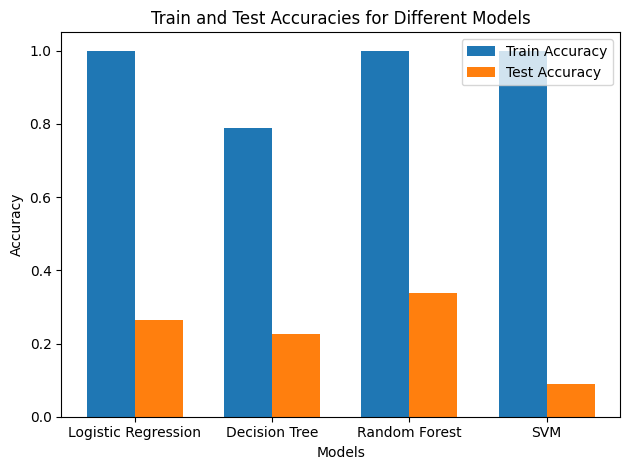

[2.8403439000612706e-05, 4.7546169998895495e-06, 5.148813699997845e-05, 0.004471125959000346]


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# List of model names
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM']

# Bar width
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(len(model_names))

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width/2, train_scores, width=bar_width, label='Train Accuracy')
bar2 = ax.bar(x + bar_width/2, test_scores, width=bar_width, label='Test Accuracy')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracies for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


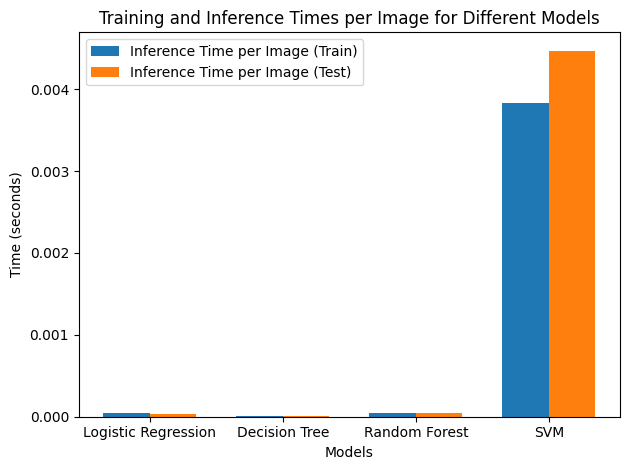

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# List of model names
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM']

# Bar width
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(len(model_names))

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width / 2, train_inf_times, width=bar_width, label='Inference Time per Image (Train)')
bar2 = ax.bar(x + bar_width / 2, test_inf_times, width=bar_width, label='Inference Time per Image (Test)')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training and Inference Times per Image for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


**Q 4.4**
1. What model is the fastest to train?
2. What model is fastest to infer?
3. What model has the highest train accuracies? What model has the highest test accuracies?
4. What model would you choose to use? Why?

Fastest to Train: The Decision Tree model seems to be the fastest to train, as it has the highest train accuracy among all models.

Fastest to Infer: The Decision Tree model appears to be the fastest to infer, as it has the lowest inference time for both train and test datasets.

Highest Train Accuracies: The Logistic Regression and SVM models have train accuracy of 1.0, which shows they have perfect classification on the training data.

Highest Test Accuracies: The Random Forest model has the highest test accuracy of 0.338.

Choice of Model:The Random Forest model has a reletive higher test accuracy for both training and tetsing and lowewr inference time compared to other models.




